In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from IPython.display import display, Latex
from matplotlib.colors import LogNorm, Normalize


from matplotlib.ticker import LogLocator

os.environ['PATH'] = os.environ['PATH'] + ':' + os.path.expanduser('~/texlive2025/bin/x86_64-linux/')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

sns.set_style("whitegrid")
sns.set_palette("husl")

In [5]:
datasets = ['adult', 'folktables', 'hmda']
dataset_names = {'adult': 'Adult', 'folktables': 'Folktables', 'hmda': 'HMDA'}

model_classes = ['logistic', 'RF', 'gbt']
model_class_names = {'logistic': 'Logistic Regression', 'RF': 'Random Forest', 'gbt': 'Gradient Boosted Trees'}

model_classes_extended = model_classes + ["fl_" + model_class for model_class in model_classes]
model_classes_extended_names = model_class_names.copy()
for model_class in model_classes:
    model_classes_extended_names["fl_" + model_class] = "Fairlearn " + model_class_names[model_class]

fig_width = 8.5
fig_height = 6.5

bigfont = 20
smallerfont = 17


In [6]:
def get_ests(dataset, model_class, with_mrl_assm, max_num_datasets, fairlearn):
    est_means = np.zeros(T)
    true_cei_means = np.zeros(T)
    est_sds = np.zeros(T)
    true_cei_sds = np.zeros(T)
    hi_est = np.zeros(T)
    lo_est = np.zeros(T)
    hi_true_cei = np.zeros(T)
    lo_true_cei = np.zeros(T)

    for i in range(max_num_datasets):
        fl_prefix = "fl_" if fairlearn else ""
        derived_data_fname = f'algo_data/{dataset}_{fl_prefix}{model_class}_{i}.csv' if not with_mrl_assm else f'algo_data/{dataset}_{fl_prefix}{model_class}_mrl_{i}.csv'
        if not os.path.exists(derived_data_fname):
            print(f"File {derived_data_fname} does not exist")
            continue
        derived_data = pd.read_csv(derived_data_fname)

        est_var_prefix = "no_assm_" if not with_mrl_assm else "mrl_assm_"

        est_means += pd.to_numeric(derived_data[est_var_prefix + 'means'])
        true_cei_means += pd.to_numeric(derived_data['true_cei_means'])
        est_sds += pd.to_numeric(derived_data[est_var_prefix + 'sds'])
        true_cei_sds += pd.to_numeric(derived_data['true_cei_sds'])

    est_means /= max_num_datasets
    true_cei_means /= max_num_datasets
    est_sds /= max_num_datasets
    true_cei_sds /= max_num_datasets

    hi_est = pd.to_numeric(est_means + est_sds)
    lo_est = pd.to_numeric(est_means - est_sds)
    hi_true_cei = pd.to_numeric(true_cei_means + true_cei_sds)
    lo_true_cei = pd.to_numeric(true_cei_means - true_cei_sds)

    return est_means, true_cei_means, est_sds, true_cei_sds, hi_est, lo_est, hi_true_cei, lo_true_cei

def plot_cei_comparison(ax, dataset, model_class, with_mrl_assm, max_num_datasets, fairlearn):

    assert not (fairlearn and with_mrl_assm), "Cannot have both fairlearn and with_mrl_assm"

    est_means, true_cei_means, est_sds, true_cei_sds, hi_est, lo_est, hi_true_cei, lo_true_cei = get_ests(dataset, model_class, False, max_num_datasets, False)
    if fairlearn:
        fl_est_means, fl_true_cei_means, fl_est_sds, fl_true_cei_sds, fl_hi_est, fl_lo_est, fl_hi_true_cei, fl_lo_true_cei = get_ests(dataset, model_class, False, max_num_datasets, True)
    elif with_mrl_assm:
        mrl_est_means, mrl_true_cei_means, mrl_est_sds, mrl_true_cei_sds, mrl_hi_est, mrl_lo_est, mrl_hi_true_cei, mrl_lo_true_cei = get_ests(dataset, model_class, True, max_num_datasets, False)

    if fairlearn:
        # Fairlearn
        sns.lineplot(x=range(1, T+1), y=fl_est_means, label=r'Upper bound ($\bar\mu(\hat U_t) \cdot \bar p_t(\delta)$)', linewidth=2.5, ax=ax, legend=False)
        ax.fill_between(range(1, T+1), fl_lo_est, fl_hi_est, alpha=0.2)
        sns.lineplot(x=range(1, T+1), y=fl_true_cei_means, label=r'Full information ($g(\hat U_t)$)', linewidth=2.5, ax=ax, legend=False)
        ax.fill_between(range(1, T+1), fl_lo_true_cei, fl_hi_true_cei, alpha=0.2)
        # Non-fairlearn
        sns.lineplot(x=range(1, T+1), y=est_means, label=r'Non-Fairlearn Upper bound (Fig. 1)', linewidth=2.5, ax=ax, legend=False, color='C0', linestyle='--', alpha=0.5)
        sns.lineplot(x=range(1, T+1), y=true_cei_means, label=r'Non-Fairlearn Full information (Fig. 1)', linewidth=2.5, ax=ax, legend=False, color='C1', linestyle='--', alpha=0.5)
    elif with_mrl_assm:
        # MRL
        sns.lineplot(x=range(1, T+1), y=mrl_est_means, label=r'Data-driven CEI Upper bound ($\bar\mu(\hat U_t) \cdot \bar p_t(\delta)$)', linewidth=2.5, ax=ax, legend=False)
        ax.fill_between(range(1, T+1), mrl_lo_est, mrl_hi_est, alpha=0.2)
        sns.lineplot(x=range(1, T+1), y=mrl_true_cei_means, label=r'Full information ($g(\hat U_t)$)', linewidth=2.5, ax=ax, legend=False)
        ax.fill_between(range(1, T+1), mrl_lo_true_cei, mrl_hi_true_cei, alpha=0.2)
        # Non-MRL
        sns.lineplot(x=range(1, T+1), y=est_means, label=r'Trivial CEI Upper bound (Fig. 1)', linewidth=2.5, ax=ax, legend=False, color='C0', linestyle='--', alpha=0.5)
    else:
        sns.lineplot(x=range(1, T+1), y=true_cei_means, label=r'Full information ($g(\hat U_t)$)', linewidth=2.5, ax=ax, legend=False)
        ax.fill_between(range(1, T+1), lo_true_cei, hi_true_cei, alpha=0.2)
        sns.lineplot(x=range(1, T+1), y=est_means, label=r'Upper bound ($\bar\mu(\hat U_t) \cdot \bar p_t(\delta)$)', linewidth=2.5, ax=ax, legend=False)
        ax.fill_between(range(1, T+1), lo_est, hi_est, alpha=0.2)
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[], numticks=5))
    ax.set_ylabel('')
    ax.set_xlabel('')
    ylower = 10e-6
    ax.set_ylim(ylower, 0.6)
    ax.set_xlim(1, T)


def plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=1, fairlearn=False, num_legend_cols=2):
    fig, axes = plt.subplots(3, len(model_classes), figsize=(fig_width*1.5, fig_height*1.5))

    for j, dataset in enumerate(datasets):
        for i, model_class in enumerate(model_classes):
            plot_cei_comparison(axes[i][j], dataset, model_class, with_mrl_assm, max_num_datasets, fairlearn)

    fig.supxlabel('Iteration', fontsize=bigfont)
    fig.supylabel('Marginal Gain', fontsize=bigfont, x=-0.005)

    for i, model_class in enumerate(model_classes):
        mc_name = model_class_names[model_class] if not fairlearn else "Fairlearn " + model_class_names[model_class]
        axes[i][0].set_ylabel(mc_name, fontsize=smallerfont)

    for i, ds in enumerate(datasets):
        axes[0][i].set_title(dataset_names[ds], fontsize=smallerfont)


    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.53, 1.12), ncol=num_legend_cols, fontsize=bigfont, frameon=True, fancybox=True, shadow=True)

    fig.tight_layout()
    
    fig_fname_postfix = "" if not with_mrl_assm else "_mrl"
    fig_fname_postfix += "" if not fairlearn else "_fairlearn"
    fig.savefig(f'cei_comparison{fig_fname_postfix}.svg', format='svg', dpi=300, bbox_inches='tight')


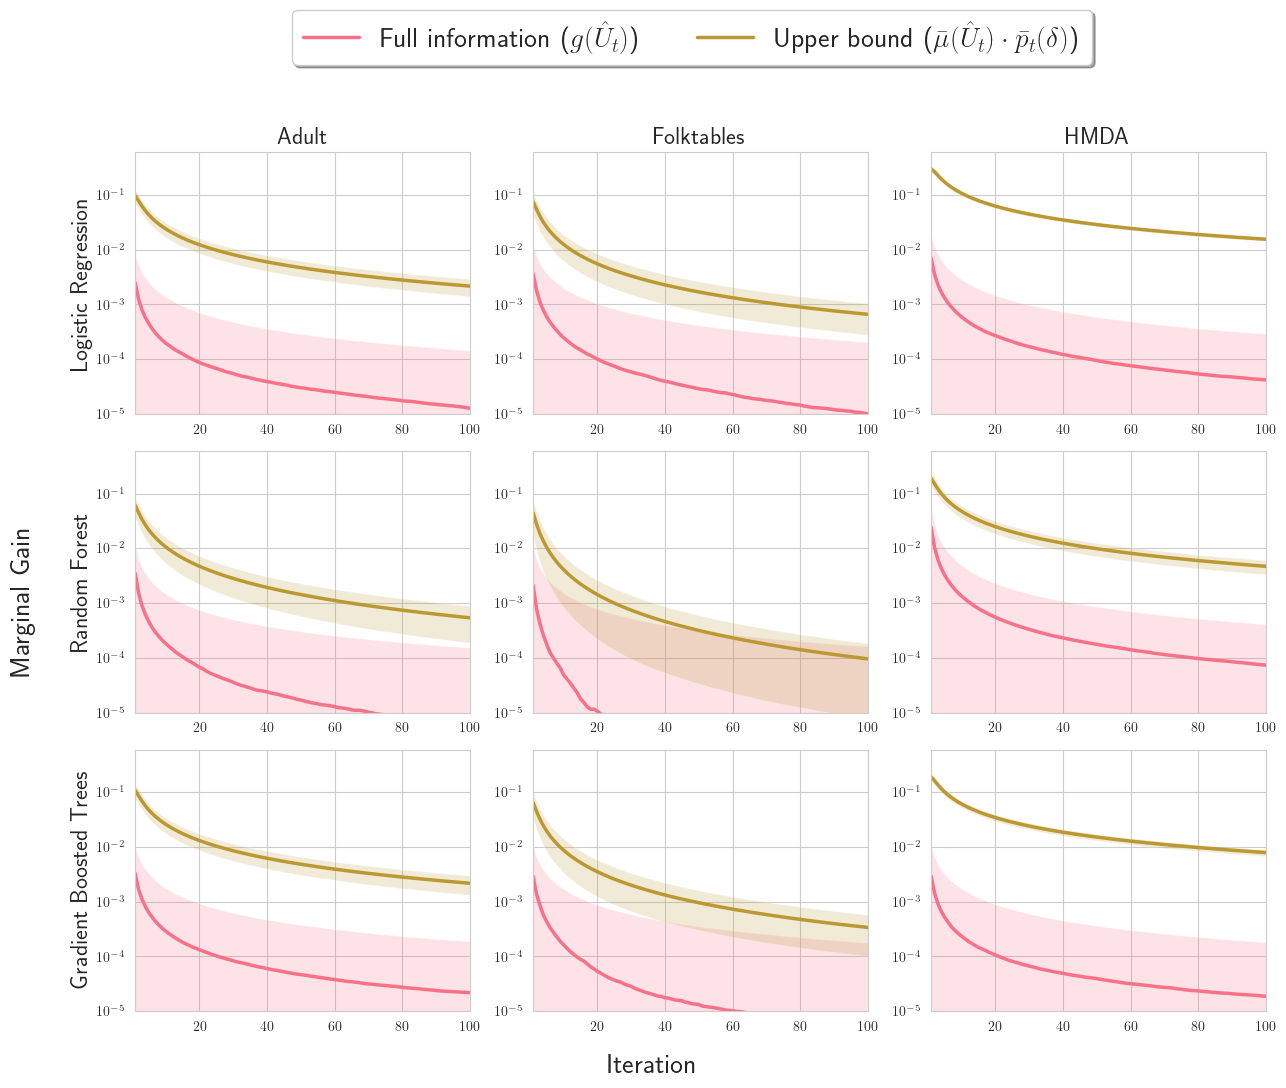

In [8]:
max_num_datasets = 45
delta = 0.05
T = 100 # number of model training iterations
plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=max_num_datasets, fairlearn=False)


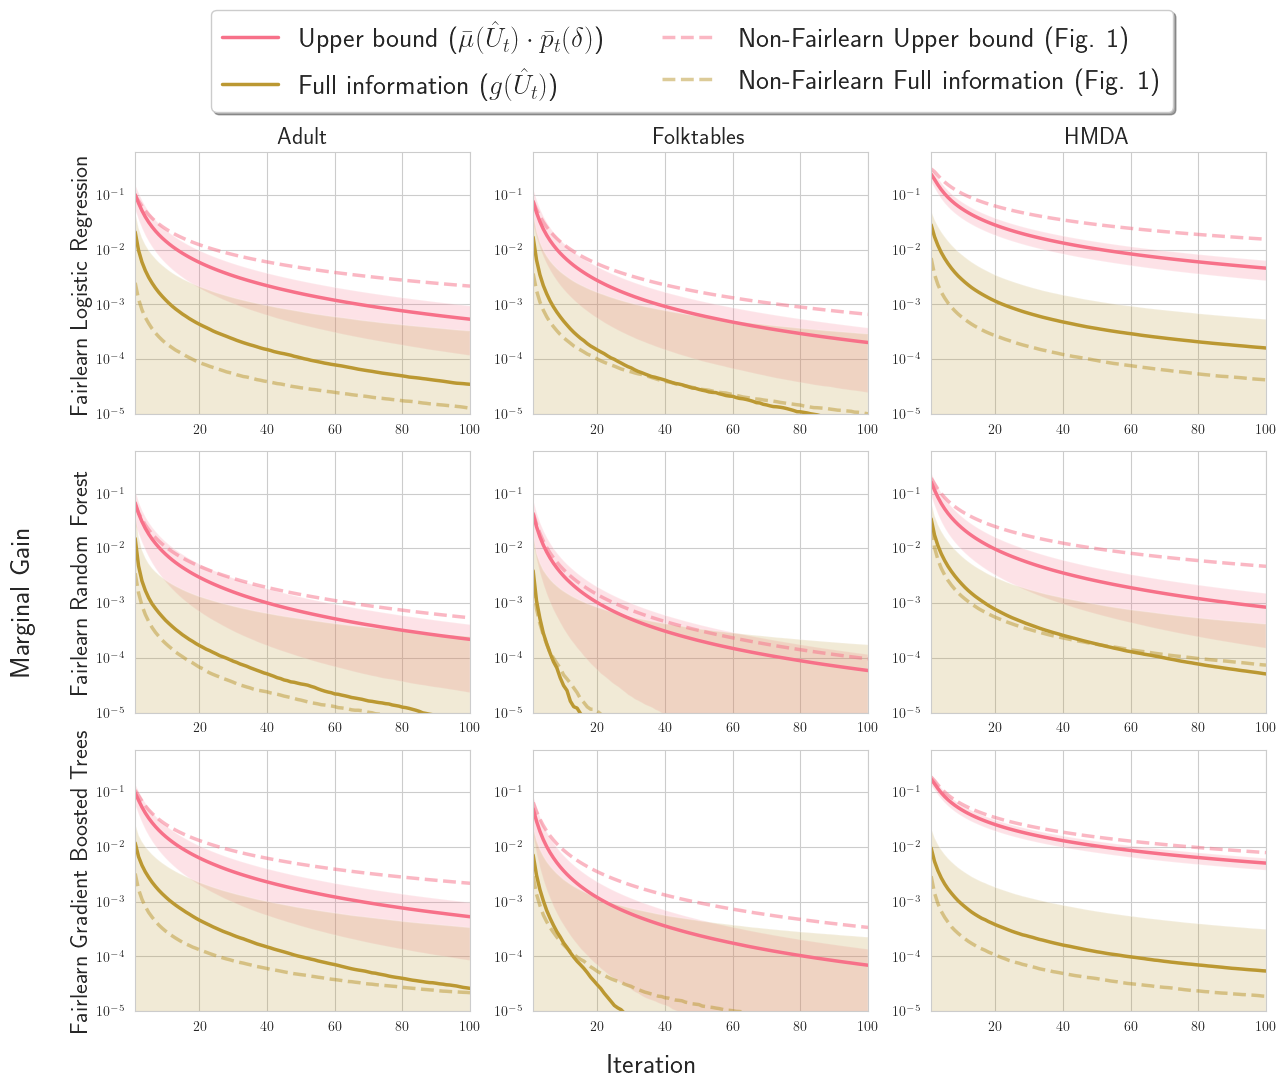

In [9]:
plot_cei_comparison_all(with_mrl_assm=False, max_num_datasets=max_num_datasets, fairlearn=True)


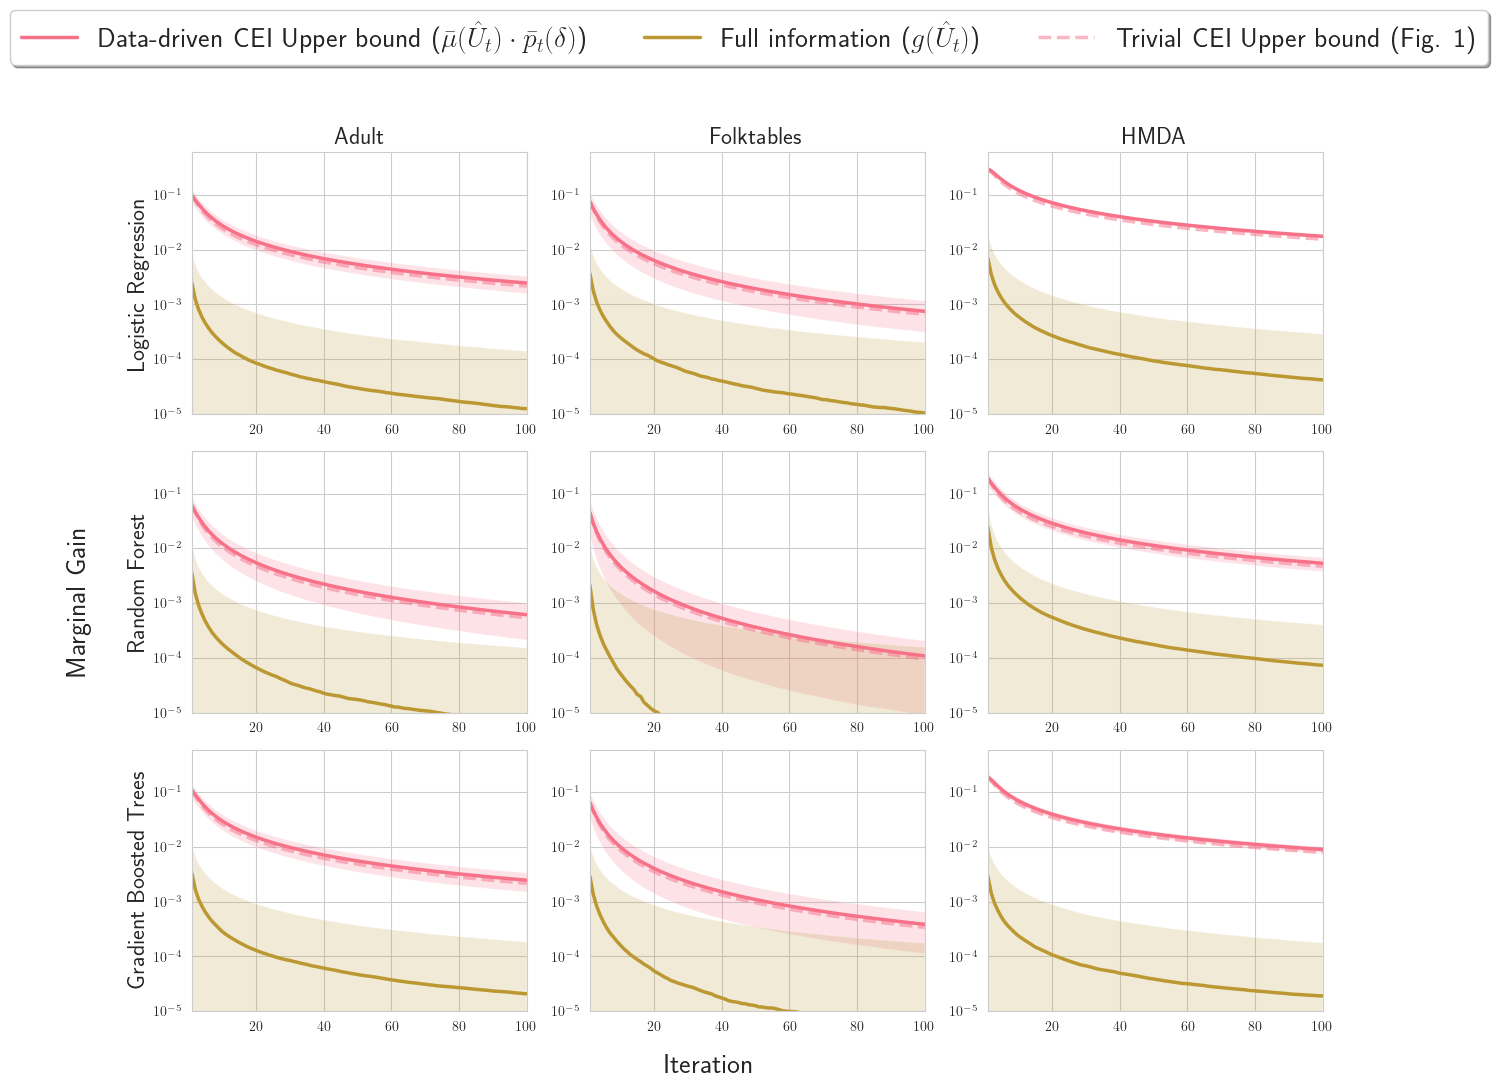

In [10]:
plot_cei_comparison_all(with_mrl_assm=True, max_num_datasets=max_num_datasets, fairlearn=False, num_legend_cols=3)


In [13]:
max_num_datasets = 45
srg_rows = []
accuracy_rows = []
miscoverage_rows = []

model_classes_extended = model_classes + ["fl_" + model_class for model_class in model_classes]
model_classes_extended_names = model_class_names.copy()
for model_class in model_classes:
    model_classes_extended_names["fl_" + model_class] = "Fairlearn " + model_class_names[model_class]


srg_means = {}
srg_stds = {}
accuracy_means = {}
accuracy_stds = {}

for dataset in datasets:
    print(dataset)
    srg_means[dataset] = np.zeros(len(model_classes_extended))
    srg_stds[dataset] = np.zeros(len(model_classes_extended))
    accuracy_means[dataset] = np.zeros(len(model_classes_extended))
    accuracy_stds[dataset] = np.zeros(len(model_classes_extended))
    num_valid_files = 0
    for fileno in tqdm(range(max_num_datasets)):
        results = pd.read_csv(f'./results_data/{dataset}_results_{fileno}.csv')
        results_fairlearn = pd.read_csv(f'./results_data/{dataset}_fairlearn_results_{fileno}.csv')

        srg_means_i = np.concatenate([np.array([np.mean(results[f"{model_class}_df_SRG"]) for model_class in model_classes]), np.array([np.mean(results_fairlearn[f"fl_{model_class}_df_SRG"]) for model_class in model_classes])])
        srg_stds_i = np.concatenate([np.array([np.std(results[f"{model_class}_df_SRG"]) for model_class in model_classes]), np.array([np.std(results_fairlearn[f"fl_{model_class}_df_SRG"]) for model_class in model_classes])])
        accuracy_means_i = np.concatenate([np.array([np.mean(results[f"{model_class}_df_accuracy"]) for model_class in model_classes]), np.array([np.mean(results_fairlearn[f"fl_{model_class}_df_accuracy"]) for model_class in model_classes])])
        accuracy_stds_i = np.concatenate([np.array([np.std(results[f"{model_class}_df_accuracy"]) for model_class in model_classes]), np.array([np.std(results_fairlearn[f"fl_{model_class}_df_accuracy"]) for model_class in model_classes])])
        num_valid_files += 1
        # except:
        #     print(f'File not found: results_data/{dataset}_results_{fileno}.csv')
        #     continue

        srg_means[dataset] += srg_means_i
        srg_stds[dataset] += srg_stds_i
        accuracy_means[dataset] += accuracy_means_i
        accuracy_stds[dataset] += accuracy_stds_i

    srg_means[dataset] /= num_valid_files
    srg_stds[dataset] /= num_valid_files
    accuracy_means[dataset] /= num_valid_files

for i, model_class in enumerate(model_classes_extended):
    srg_rows.append(f"{model_classes_extended_names[model_class]} & " + " & ".join([f"{srg_means[dataset][i]:0.3f} ({srg_stds[dataset][i]:0.3f})" for dataset in datasets]) + " \\")
    accuracy_rows.append(f"{model_classes_extended_names[model_class]} & " + " & ".join([f"{accuracy_means[dataset][i]:0.3f} ({accuracy_stds[dataset][i]:0.3f})" for dataset in datasets]) + " \\")

srg_rows = "".join(srg_rows)
accuracy_rows = "".join(accuracy_rows)


adult


100%|██████████| 45/45 [00:01<00:00, 39.14it/s]


folktables


100%|██████████| 45/45 [00:01<00:00, 39.43it/s]


hmda


100%|██████████| 45/45 [00:01<00:00, 40.89it/s]


In [14]:
def display_table(rows):
    print("LaTeX Table:")
    print("\\begin{tabular}{lccc}")
    print("Model & Adult & Folktables & HMDA \\\\")
    print(rows.replace("\\", "\\\\\n"))
    print("\\end{tabular}")
    display(Latex(r"\begin{array}{lccc}" + "\n" +
                r"\text{Model} & \text{Adult} & \text{Folktables} & \text{HMDA} \\" + "\n" +
                rows.replace("\\", r"\\") +
                r"\end{array}"))

display_table(accuracy_rows)

LaTeX Table:
\begin{tabular}{lccc}
Model & Adult & Folktables & HMDA \\
Logistic Regression & 0.824 (0.044) & 0.780 (0.070) & 0.734 (0.140) \\
Random Forest & 0.818 (0.209) & 0.810 (0.228) & 0.748 (0.545) \\
Gradient Boosted Trees & 0.821 (0.088) & 0.808 (0.096) & 0.780 (0.101) \\
Fairlearn Logistic Regression & 0.824 (0.081) & 0.779 (0.096) & 0.733 (0.161) \\
Fairlearn Random Forest & 0.819 (0.148) & 0.812 (0.134) & 0.751 (0.453) \\
Fairlearn Gradient Boosted Trees & 0.821 (0.091) & 0.807 (0.101) & 0.780 (0.114) \\

\end{tabular}


<IPython.core.display.Latex object>

In [15]:
display_table(srg_rows)

LaTeX Table:
\begin{tabular}{lccc}
Model & Adult & Folktables & HMDA \\
Logistic Regression & 0.098 (0.010) & 0.073 (0.015) & 0.300 (0.021) \\
Random Forest & 0.060 (0.013) & 0.032 (0.014) & 0.192 (0.052) \\
Gradient Boosted Trees & 0.109 (0.013) & 0.063 (0.013) & 0.194 (0.013) \\
Fairlearn Logistic Regression & 0.100 (0.046) & 0.069 (0.042) & 0.241 (0.058) \\
Fairlearn Random Forest & 0.066 (0.037) & 0.029 (0.019) & 0.164 (0.067) \\
Fairlearn Gradient Boosted Trees & 0.096 (0.030) & 0.040 (0.025) & 0.177 (0.026) \\

\end{tabular}


<IPython.core.display.Latex object>

In [16]:
miscovered_means = {}
miscovered_inf_data_means = {}

max_file_no = 50  # set to 50 according to context above

for dataset in datasets:
    for model_class in model_classes_extended:
        miscovered_entries = []
        miscovered_inf_data_entries = []
        for fileno in range(max_file_no):
            file_path = f'algo_data/{dataset}_{model_class}_{fileno}.csv'
            try:
                df = pd.read_csv(file_path)
                # Assumes that the first entry is in row 0, column 'miscovered'
                if 'miscovered' in df.columns:
                    miscovered_entries.append(df.loc[0, 'miscovered'])
                    miscovered_inf_data_entries.append(df.loc[0, 'miscovered_inf_data'])
            except Exception as e:
                # If the file does not exist or is malformed, skip it
                continue
        if len(miscovered_entries) > 0:
            avg_miscovered = sum(miscovered_entries) / len(miscovered_entries)
        else:
            avg_miscovered = np.nan
        if len(miscovered_inf_data_entries) > 0:
            avg_miscovered_inf_data = sum(miscovered_inf_data_entries) / len(miscovered_inf_data_entries)
        else:
            avg_miscovered_inf_data = np.nan
        miscovered_means[dataset + "_" + model_class] = avg_miscovered
        miscovered_inf_data_means[dataset + "_" + model_class] = avg_miscovered_inf_data


In [17]:

# Create and display a LaTeX table of "miscovered_means" where columns are datasets and rows are methods (model_classes_extended).
def miscovered_table(miscovered_means, datasets, model_classes_extended):
    # Prepare table rows as LaTeX-formatted string
    rows = ""
    for model_class in model_classes_extended:
        row = [model_classes_extended_names[model_class]]
        for dataset in datasets:
            key = f"{dataset}_{model_class}"
            val = miscovered_means.get(key, np.nan)
            if val is None or np.isnan(val):
                disp_val = "-"
            else:
                disp_val = f"{val:.3f}"
            row.append(disp_val)
        rows += " & ".join(row) + r" \\" + "\n"
    # Print LaTeX table
    print("LaTeX Table:")
    print("\\begin{tabular}{l" + "c"*len(datasets) + "}")
    print("Method & " + " & ".join(dataset_names.values()) + r" \\")
    print(rows)
    print("\\end{tabular}")
    # Display as Latex in notebook
    header = r"\text{Method} & " + " & ".join(r"\text{" + d + "}" for d in datasets) + r" \\"
    display(Latex(r"\begin{array}{l" + "c"*len(datasets) + "}" + "\n" +
                  header + "\n" +
                  rows.replace("\\", r"\\") +
                  r"\end{array}"))

miscovered_table(miscovered_means, datasets, model_classes_extended)


LaTeX Table:
\begin{tabular}{lccc}
Method & Adult & Folktables & HMDA \\
Logistic Regression & 0.006 & 0.161 & 0.000 \\
Random Forest & 0.077 & 0.381 & 0.000 \\
Gradient Boosted Trees & 0.006 & 0.196 & 0.000 \\
Fairlearn Logistic Regression & 0.219 & 0.400 & 0.000 \\
Fairlearn Random Forest & 0.273 & 0.484 & 0.045 \\
Fairlearn Gradient Boosted Trees & 0.146 & 0.475 & 0.000 \\

\end{tabular}


<IPython.core.display.Latex object>

In [18]:
miscovered_table(miscovered_inf_data_means, datasets, model_classes_extended)


LaTeX Table:
\begin{tabular}{lccc}
Method & Adult & Folktables & HMDA \\
Logistic Regression & 0.000 & 0.000 & 0.000 \\
Random Forest & 0.000 & 0.000 & 0.000 \\
Gradient Boosted Trees & 0.000 & 0.000 & 0.000 \\
Fairlearn Logistic Regression & 0.000 & 0.000 & 0.000 \\
Fairlearn Random Forest & 0.000 & 0.000 & 0.000 \\
Fairlearn Gradient Boosted Trees & 0.000 & 0.000 & 0.000 \\

\end{tabular}


<IPython.core.display.Latex object>

In [23]:
max_num_datasets = 45

srg_dct = {}
acc_dct = {}


for dataset in datasets:
    for model_class in model_classes:
        srg_all = []
        acc_all = []
        fl_srg_all = []
        fl_acc_all = []
        for fileno in range(max_num_datasets):

            file_path = f'results_data/{dataset}_results_{fileno}.csv'
            results = pd.read_csv(file_path)

            acc = results[f"{model_class}_df_accuracy"]
            srg = results[f"{model_class}_df_SRG"]

            srg_all.append(np.array(srg))
            acc_all.append(np.array(acc))

            fairlearn_file_path = f'results_data/{dataset}_fairlearn_results_{fileno}.csv'
            results = pd.read_csv(fairlearn_file_path)

            fl_acc = results[f"fl_{model_class}_df_accuracy"]
            fl_srg = results[f"fl_{model_class}_df_SRG"]

            fl_srg_all.append(np.array(fl_srg))
            fl_acc_all.append(np.array(fl_acc))

        srg_dct[dataset + "_" + model_class] = np.concatenate(srg_all)
        acc_dct[dataset + "_" + model_class] = np.concatenate(acc_all)
        srg_dct[dataset + "_fl_" + model_class] = np.concatenate(fl_srg_all)
        acc_dct[dataset + "_fl_" + model_class] = np.concatenate(fl_acc_all)





adult
folktables
hmda


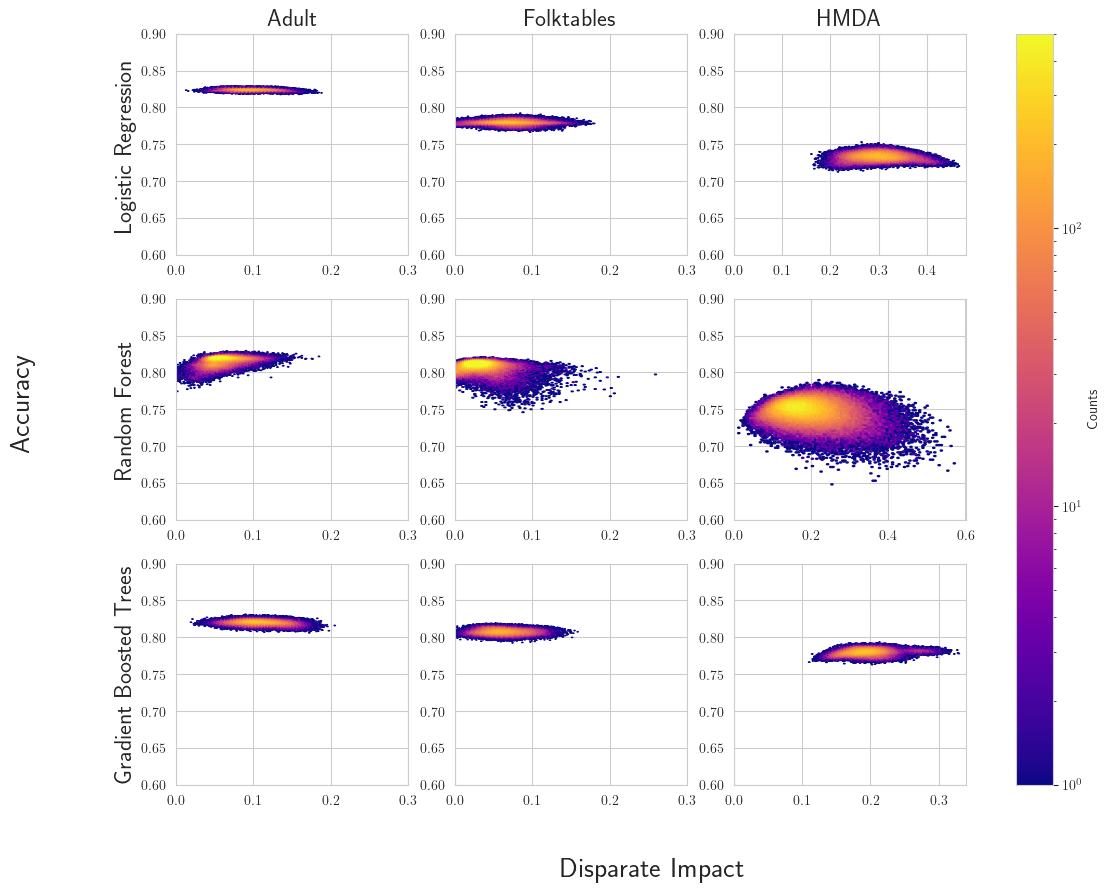

In [61]:
def plot_accuracy_srg_comparison(fairlearn=False):
    fig, axes = plt.subplots(3, 3, figsize=(fig_width*1.5, fig_height*1.5))
    norm = LogNorm(vmin=1, vmax=500)
    for j, dataset in enumerate(datasets):
        print(dataset)
        for i, model_class in enumerate(model_classes):
            model_class = model_class if not fairlearn else "fl_" + model_class
            if j == 0:
                if fairlearn:
                    axes[i,0].set_ylabel(model_classes_extended_names[model_class], fontsize=14)
                else:
                    axes[i,0].set_ylabel(model_classes_extended_names[model_class], fontsize=smallerfont)
            if i == 0:
                axes[0,j].set_title(dataset_names[dataset], fontsize=smallerfont)
            cb = axes[i,j].hexbin(srg_dct[dataset + "_" + model_class], acc_dct[dataset + "_" + model_class], norm=norm, gridsize=100, cmap='plasma')
            axes[i,j].set_ylim(0.6, 0.9)
            if j <= 1:
                axes[i,j].set_xlim(0, 0.3)
            else:
                axes[i,j].set_xlim(left=0)
                if j <= 1:
                    axes[i,j].set_xlim(right=0.5)
    cbar = fig.colorbar(cb, ax=axes, location='right')
    cbar.set_label("Counts")
    fig.supxlabel('Disparate Impact', fontsize=bigfont)
    fig.supylabel('Accuracy', fontsize=bigfont, x=-0.005)
    # fig.tight_layout()
    return fig, axes

fig, axes = plot_accuracy_srg_comparison(fairlearn=False)
plt.savefig('accuracy_srg_comparison.png', format='png', dpi=300, bbox_inches='tight')

adult
folktables
hmda


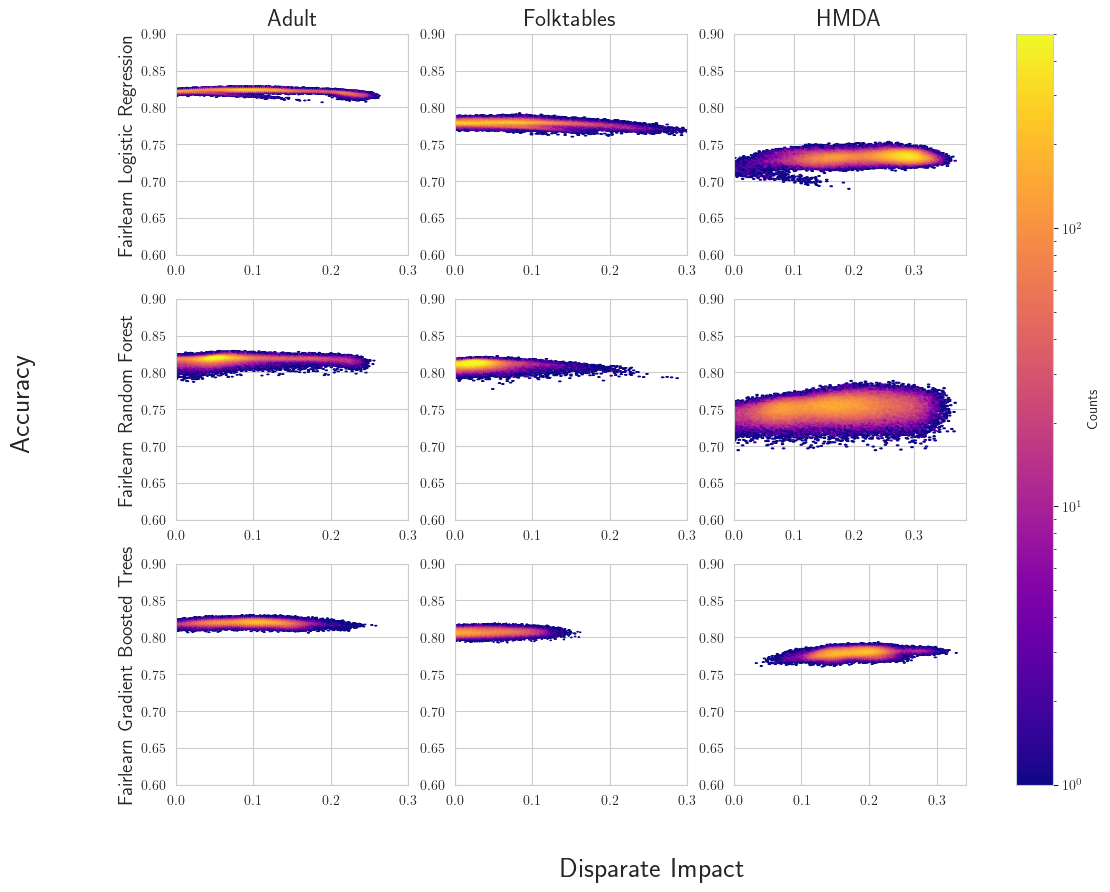

In [62]:
fig, axes = plot_accuracy_srg_comparison(fairlearn=True)
plt.savefig('accuracy_srg_comparison_fairlearn.png', format='png', dpi=300, bbox_inches='tight')

# Miscoverage analysis

In [58]:
## Violations of the non-decreasing selection effect assumption


def compute_selection_effect_difference(results, u_obs, u_true, model):
    less_inds = results[results[f'{model}_eval_SRG'] < u_obs].index
    n_less = len(less_inds)
    p_less = n_less / len(results)
    diff_cond = (results.loc[less_inds, f'{model}_df_SRG'] - results.loc[less_inds, f'{model}_eval_SRG']).mean()
    return u_true - u_obs - p_less * diff_cond

def plot_selection_effect_difference(fairlearn=False):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(fig_width*1.5, fig_height*1.5))
    fairlearn_prefix = "fairlearn_" if fairlearn else ""
    fl_prefix = "fl_" if fairlearn else ""
    norm = LogNorm(vmin=1, vmax=15)

    for i, dataset in enumerate(datasets):
        for j, model in enumerate(model_classes):
            diffs = []
            percentiles_all = []
            print(dataset, model)
            for fileno in range(max_num_files):
                results = pd.read_csv(f'results_data/{dataset}_{fairlearn_prefix}results_{fileno}.csv')
                inds = results[f'{fl_prefix}{model}_eval_SRG'].argsort()
                percentiles = np.linspace(0, 100, len(results))
                n_to_plot = max_percentile * len(results) // 100

                results_short = results.iloc[inds[:n_to_plot]]

                for _, row in results_short.iterrows():
                    u_obs = row[f'{fl_prefix}{model}_eval_SRG']
                    u_true = row[f'{fl_prefix}{model}_df_SRG']
                    diff = compute_selection_effect_difference(results, u_obs, u_true, fl_prefix + model)
                    diffs.append(diff)
                percentiles_all.append(percentiles[:n_to_plot])
            y = pd.Series(diffs)
            x = np.concatenate(percentiles_all)

            cb = axes[j, i].hexbin(x, y, norm=norm, gridsize=85, cmap='plasma')
            axes[j, i].axhline(0, color='k', linestyle='--', linewidth=3)
            if fairlearn:
                axes[j, i].set_ylim(bottom=-0.1, top=0.15)
            else:
                axes[j, i].set_ylim(bottom=-0.1, top=0.15)
            axes[j, i].set_xlim(left=0, right=5)

    for i, model_class in enumerate(model_classes):
        fairlearn_prefix = "Fairlearn " if fairlearn else ""
        mc_name = model_class_names[model_class] 
        if fairlearn:
            axes[i][0].set_ylabel(f"{fairlearn_prefix}{mc_name}", fontsize=14)
        else:
            axes[i][0].set_ylabel(f"{fairlearn_prefix}{mc_name}", fontsize=smallerfont)

    for i, ds in enumerate(datasets):
        axes[0][i].set_title(dataset_names[ds], fontsize=smallerfont)

    cbar = fig.colorbar(cb, ax=axes, location='right')
    cbar.set_label("Counts")

    fig.supxlabel("$\hat Q_t$ percentile", fontsize=bigfont)
    fig.supylabel("Selection Effect Difference", fontsize=bigfont)
    fairlearn_prefix = "fairlearn_" if fairlearn else ""

    plt.savefig(f'{fairlearn_prefix}selection_effect_difference.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()


adult logistic
adult RF
adult gbt
folktables logistic
folktables RF
folktables gbt
hmda logistic
hmda RF
hmda gbt


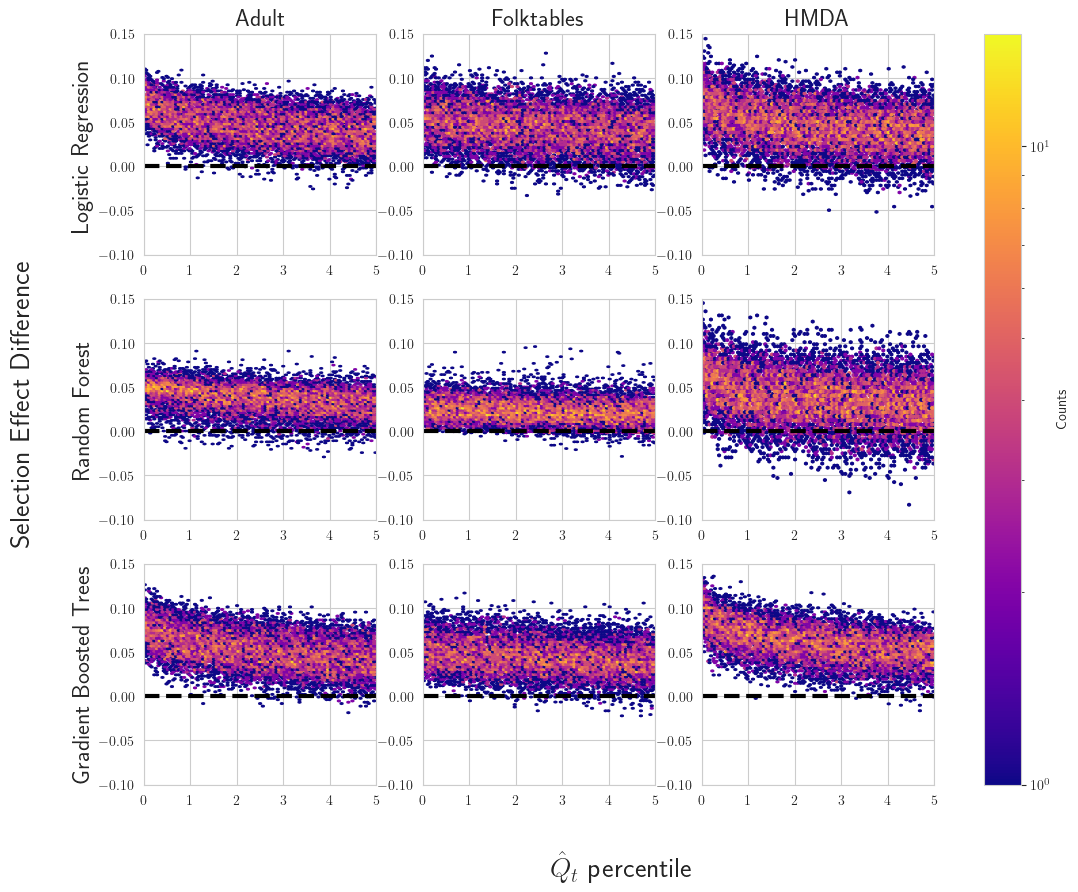

In [59]:
max_num_files = 45
max_percentile = 5

plot_selection_effect_difference(fairlearn=False)

adult logistic


adult RF
adult gbt
folktables logistic
folktables RF
folktables gbt
hmda logistic
hmda RF
hmda gbt


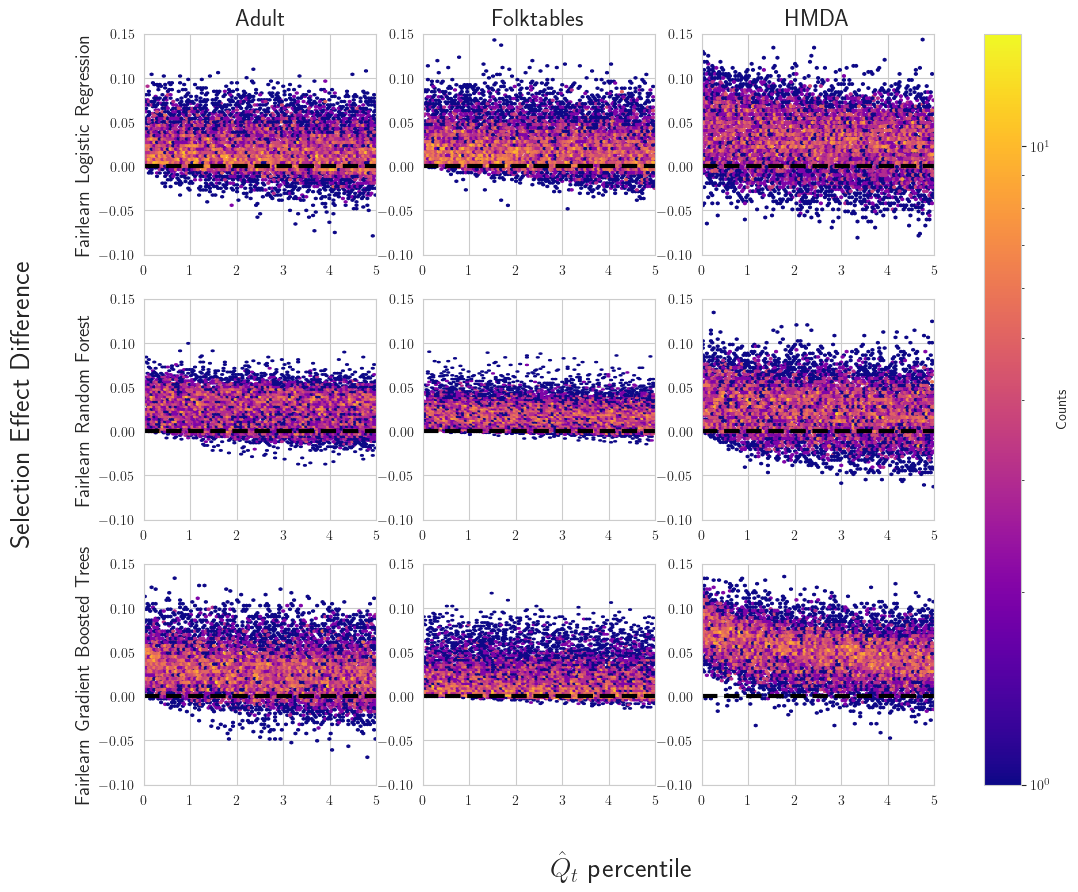

In [60]:
plot_selection_effect_difference(fairlearn=True)